In [1]:
!pip install myqlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.3/498.3 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 6.7

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [2]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]

# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0
    # we sum over all edges (cf. definition of the Hamiltonian in Q1)
    for i, j in edges:
      # we add one if the vertices are in different sets, else we substract one
      val += (-1)**(b[i] + b[j])
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print("The lowest energy is:", best_value)
print("The optimal cut is:", best_b)

The lowest energy is: -5
The optimal cut is: [1, 0, 0, 1, 1]


#### visualization of the graph

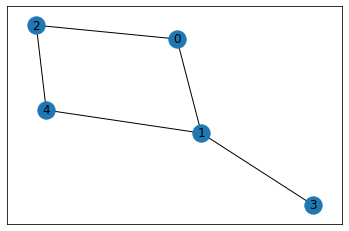

In [3]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [4]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [5]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [6]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    # We apply a rotation RX on all qubits with the same angle theta
    for i in range(n_qubits):
      layer.apply(RX(theta), i)  
    # As in question 1, we add a "cost" for each edge 
    for i, j in edges:
      layer.apply(U_ZZ(beta), i, j)
    return layer

### Question 4

In [7]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit

    # We apply the Hadamard gate to all qubits to achieve superposition
    for i in range(n_qubits):
      prog.apply(H, qubits[i])
    
    # We add n_layers QAOA layers with angle parameters alpha_i, beta_i
    for i in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*i], parameters[2*i+1]), qubits)

    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    # BEGIN TODO
    obs = 0
    for sample in result:
      obs_sample = 0
      # this loop is over all 2**nqubits states.
      # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
      b = [int(sample.state.bitstring[i]) for i in range(n_qubits)]
      # TODO: Complete the computation below:
      # Same computation as question 2, but we must weight the energy values by
      # the corresponding probabilities
      for i, j in edges:
        obs_sample += (-1)**(b[i] + b[j])
      obs_sample *= sample.probability 
      obs += obs_sample
      
    # END TODO
    return obs
    
        

In [8]:
import numpy as np

In [9]:
from scipy.optimize import minimize

### Random initialisation

### Question 5: 
réponse à la question:

Number of layers used: 2
Energy value:-0.00
Energy value:-0.33
Energy value:-0.35
Energy value:-0.56
Energy value:-0.62
Energy value:-0.62
Energy value:-0.62
Energy value:-0.62
Energy value:-0.62

Number of layers used: 4
Energy value:1.99
Energy value:0.28
Energy value:-0.47
Energy value:-1.06
Energy value:-1.15
Energy value:-1.67
Energy value:-2.04
Energy value:-2.16
Energy value:-2.35
Energy value:-2.60
Energy value:-2.77
Energy value:-2.81
Energy value:-2.85
Energy value:-2.87
Energy value:-2.89
Energy value:-2.90
Energy value:-2.91
Energy value:-2.91
Energy value:-2.91
Energy value:-2.91
Energy value:-2.91

Number of layers used: 6
Energy value:0.42
Energy value:-1.34
Energy value:-1.54
Energy value:-1.76
Energy value:-2.20
Energy value:-2.25
Energy value:-2.32
Energy value:-2.47
Energy value:-2.76
Energy value:-3.00
Energy value:-3.08
Energy value:-3.20
Energy value:-3.27
Energy value:-3.35
Energy value:-3.39
Energy value:-3.64
Energy value:-3.74
Energy value:-3.88
Energy value:-

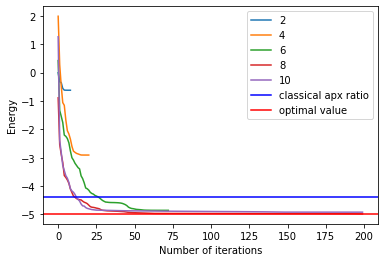

In [10]:
import matplotlib.pylab as plt

List_nlayers = [2, 4, 6, 8, 10] 
# We test different numbers of QAOA layers to get closer to the optimal value
for nlayers in List_nlayers:
    print("Number of layers used:%2d" % nlayers)
    num_params = 2*nlayers # 2 angle parameters alpha_i, beta_i for each layer
    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        # print(eva, end=' ')
        print("Energy value:%.2f" % eva)

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,
                       options={'maxiter':200})
    plt.plot(back_trace,label=str(nlayers))
    print()
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.legend()
plt.show()

According to the graph and the energy values printed above, it looks like at least 10 layers are needed for QAOA to reach the optimal value for the graph 6.

Let us display the solutions found by QAOA with the associate probabilities. The following code gives us the results. We decided to show the 2 most likely results for symetry reasons, we will talk about it later.

In [11]:
prog = Program()
qubits = prog.qalloc(nqubits)

parameters = opt_res.x # best values for the parameters alpha_i, beta_i

# We now reproduce the QAOA circuit with the optimal parameters
# Here, nlayers = 10 (last number of layers tested above)
for i in range(nqubits):
  prog.apply(H, qubits[i])
for i in range(nlayers):
  prog.apply(one_qaoa_layer(nqubits, edges, parameters[2*i], parameters[2*i+1]), qubits)

circ = prog.to_circ()
job = circ.to_job(aggregate_data=True)
qpu = get_default_qpu()
result = qpu.submit(job)
# result now contains all state vectors with their corresponding probabilities
# we only extract the 2 most probable solutions

# First solution found:
max_prob = 0
for sample in result:
    if sample.probability > max_prob:
      max_prob = sample.probability
      best_state = sample.state
      # we convert the state vector |x0...xn> to [x0, ..., xn] to make it more visual
      best_cut = [int(sample.state.bitstring[i]) for i in range(nqubits)] 

# Second solution found:
second_max_prob = 0
for sample in result:
  if sample.state != best_state:
    if sample.probability > second_max_prob:
      second_max_prob = sample.probability
      second_best_cut = [int(sample.state.bitstring[i]) for i in range(nqubits)]

print("Best cut: %s with probability %.4f" % (best_cut, max_prob))
print("Second best cut: %s with probability %.4f" % (second_best_cut, second_max_prob))
print("Expected best cut: %s" % best_b)

Best cut: [0, 1, 1, 0, 0] with probability 0.4886
Second best cut: [1, 0, 0, 1, 1] with probability 0.4886
Expected best cut: [1, 0, 0, 1, 1]


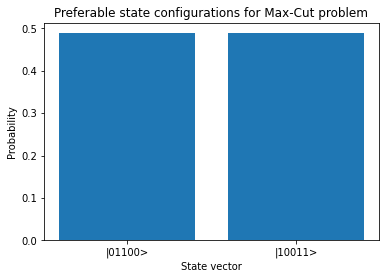

In [12]:
State_vectors = [str(sample.state) for sample in result if sample.probability > 1e-2] # Only displays state vector whose amplitude is above 1% (arbitrary)
Probabilities = [sample.probability for sample in result if sample.probability > 1e-2]
plt.bar(State_vectors, Probabilities)
plt.xlabel("State vector")
plt.ylabel("Probability")
plt.title("Preferable state configurations for Max-Cut problem")
plt.show()

We can see here there are two solutions for the Max-Cut problem. This is due to the fact that the problem is symetric: if we swap $S$ and $V \setminus S$, the number of cuts remains the same and thus it is still a solution to our optimization problem. Here, it essentially consists in swapping all $0$'s and $1$'s.

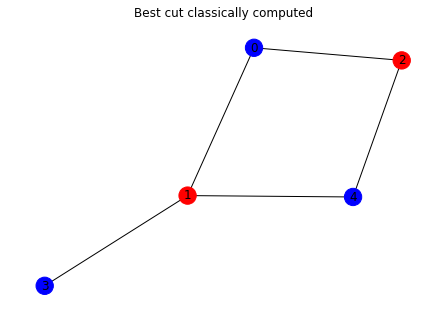

In [61]:
G = nx.Graph()
color_map = []
for i,j in edges:
    G.add_edge(i,j)

for node in G:
  if best_b[node] == 1:
    color_map.append('blue')
  else:
    color_map.append('red')
nx.draw(G, node_color=color_map, with_labels=True)
plt.title("Best cut classically computed")
plt.show()

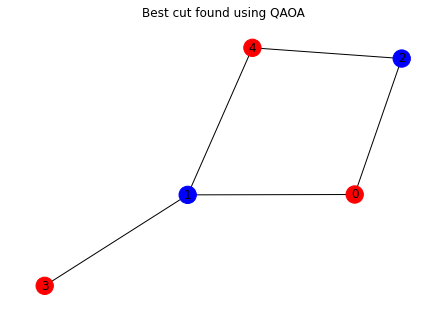

In [62]:
G = nx.Graph()
color_map = []
for i,j in edges:
    G.add_edge(i,j)

for node in G:
  if best_cut[node] == 1:
    color_map.append('blue')
  else:
    color_map.append('red')
nx.draw(G, node_color=color_map, with_labels=True)
plt.title("Best cut found using QAOA")
plt.show()

Good news! The best cuts found using the 2 different techniques are the same.

### Question 6: smart initialization

To find the optimal initialization parameters for $\alpha_k, \beta_k$, we can write:
$$\begin{align}
e^{\int_0^T H(s)ds} &\simeq \text{exp}\left[-i \frac{T}{p}\sum_{k=1}^p H\left(\frac{kT}{p}\right)\right] \\
&\simeq \text{exp}\left[-i \frac{T}{p}\sum_{k=1}^p \left(\left(1-\frac{kT}{p}\right)\sum_{k'} \sigma_x^{k'} + \frac{k}{p}H_c \right)\right] \\
&\simeq \prod_{k=1}^p \text{exp}\left[-i \frac{T}{p} \left(1-\frac{kT}{p}\right)\sum_{k'} \sigma_x^{k'}\right] \text{exp}\left(-i \frac{kT}{p^2}H_c\right) \\
\end{align}$$

We can therefore identify $\frac{\alpha_k}{2} = \frac{T}{p} \left(1-\frac{kT}{p}\right)$ and $\beta_k = \frac{kT}{p^2}$.

First, we will take $T= 1$, where $T$ corresponds to the transition time.

Number of layers used: 2
Energy value:-1.80
Energy value:-2.01
Energy value:-2.33
Energy value:-2.38
Energy value:-2.39
Energy value:-2.39
Energy value:-2.39

Number of layers used: 4
Energy value:-1.75
Energy value:-1.81
Energy value:-2.32
Energy value:-3.21
Energy value:-3.61
Energy value:-3.89
Energy value:-4.25
Energy value:-4.42
Energy value:-4.49
Energy value:-4.58
Energy value:-4.63
Energy value:-4.65
Energy value:-4.66
Energy value:-4.66
Energy value:-4.66
Energy value:-4.66
Energy value:-4.66
Energy value:-4.66

Number of layers used: 6
Energy value:-1.56
Energy value:-2.41
Energy value:-3.35
Energy value:-3.74
Energy value:-4.22
Energy value:-4.34
Energy value:-4.50
Energy value:-4.54
Energy value:-4.61
Energy value:-4.71
Energy value:-4.74
Energy value:-4.79
Energy value:-4.82
Energy value:-4.83
Energy value:-4.84
Energy value:-4.85
Energy value:-4.85
Energy value:-4.86
Energy value:-4.87
Energy value:-4.88
Energy value:-4.89
Energy value:-4.90
Energy value:-4.92
Energy valu

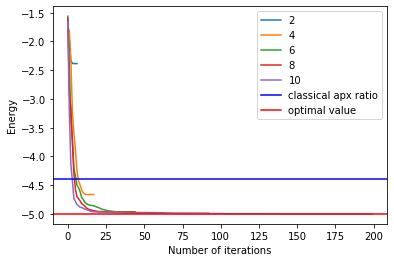

In [63]:
T = 1.

List_nlayers = [2, 4, 6, 8, 10]

for nlayers in List_nlayers:

    print("Number of layers used:%2d" % nlayers)
    back_trace = []

    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print("Energy value:%.2f" % eva)

    # TODO implement parameter init
    parameters_init = []
    for k in range(nlayers):
      alpha_k = 2*T / nlayers * (1 - k / nlayers)  # optimal initialization angle alpha_k (computed above)
      beta_k = T * k / (nlayers ** 2)  # optimal initialization angle beta_k (computed above)
      parameters_init.append(alpha_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,
                       options={'maxiter':200})
    plt.plot(back_trace,label=str(nlayers))
    print()

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.legend()

We can notice here that the convergence is way faster than before: for example with 10 QAOA layers, we reach the optimal value after around 40 iterations, while the previous random initialization parameters reached -4.92 (the optimal value being -5) after 200 iterations. Besides, we can see that we need less QAOA layers: for $p \geq 6$ layers, it feels like we almost reach the optimal value ver fast (around 30 iterations). 

In [64]:
prog = Program()
qubits = prog.qalloc(nqubits)

parameters = opt_res.x # best values for the parameters alpha_i, beta_i

# We now reproduce the QAOA circuit with the optimal parameters
# Here, nlayers = 10 (last number of layers tested above)
for i in range(nqubits):
  prog.apply(H, qubits[i])
for i in range(nlayers):
  prog.apply(one_qaoa_layer(nqubits, edges, parameters[2*i], parameters[2*i+1]), qubits)

circ = prog.to_circ()
job = circ.to_job(aggregate_data=True)
qpu = get_default_qpu()
result = qpu.submit(job)
# result now contains all state vectors with their corresponding probabilities
# we only extract the 2 most probable solutions

# First solution found:
max_prob = 0
for sample in result:
    if sample.probability > max_prob:
      max_prob = sample.probability
      best_state = sample.state
      # we convert the state vector |x0...xn> to [x0, ..., xn] to make it more visual
      best_cut = [int(sample.state.bitstring[i]) for i in range(nqubits)] 

# Second solution found:
second_max_prob = 0
for sample in result:
  if sample.state != best_state:
    if sample.probability > second_max_prob:
      second_max_prob = sample.probability
      second_best_cut = [int(sample.state.bitstring[i]) for i in range(nqubits)]

print("Best cut: %s with probability %.4f" % (best_cut, max_prob))
print("Second best cut: %s with probability %.4f" % (second_best_cut, second_max_prob))
print("Expected best cut: %s" % best_b)

Best cut: [0, 1, 1, 0, 0] with probability 0.5000
Second best cut: [1, 0, 0, 1, 1] with probability 0.5000
Expected best cut: [1, 0, 0, 1, 1]


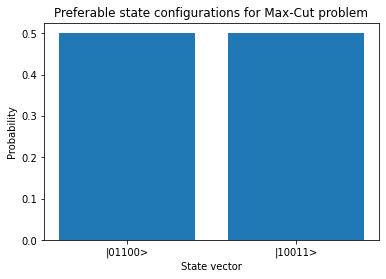

In [65]:
State_vectors = [str(sample.state) for sample in result if sample.probability > 1e-2] # Only displays state vector whose amplitude is above 1% (arbitrary)
Probabilities = [sample.probability for sample in result if sample.probability > 1e-2]
plt.bar(State_vectors, Probabilities)
plt.xlabel("State vector")
plt.ylabel("Probability")
plt.title("Preferable state configurations for Max-Cut problem")
plt.show()

Notice here that the probabilities of the 2 (symmetric) solutions are 0.5000, which is the higest values we could get as the two configurations both bring the lowest energy value and are equally likely to appear; by comparison, before the probabilities were 0.4886.

We now try with a bigger $T$, i.e. when the transition is slower. Let us take $T = 10$.

Number of layers used: 2
Energy value:-1.16
Energy value:-1.43
Energy value:-1.93
Energy value:-2.36
Energy value:-2.38
Energy value:-2.39
Energy value:-2.39
Energy value:-2.39

Number of layers used: 4
Energy value:-0.89
Energy value:-2.20
Energy value:-2.46
Energy value:-2.75
Energy value:-2.82
Energy value:-2.94
Energy value:-3.12
Energy value:-3.19
Energy value:-3.29
Energy value:-3.31
Energy value:-3.31
Energy value:-3.32
Energy value:-3.32
Energy value:-3.32
Energy value:-3.32
Energy value:-3.32
Energy value:-3.32
Energy value:-3.32

Number of layers used: 6
Energy value:-0.91
Energy value:-2.17
Energy value:-3.08
Energy value:-3.78
Energy value:-4.27
Energy value:-4.36
Energy value:-4.38
Energy value:-4.41
Energy value:-4.46
Energy value:-4.51
Energy value:-4.57
Energy value:-4.63
Energy value:-4.67
Energy value:-4.69
Energy value:-4.71
Energy value:-4.72
Energy value:-4.73
Energy value:-4.73
Energy value:-4.73
Energy value:-4.73
Energy value:-4.73
Energy value:-4.73
Energy valu

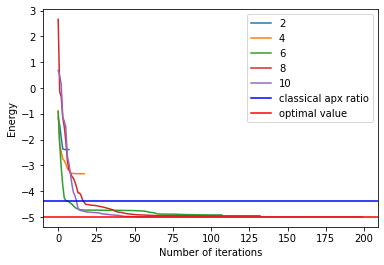

In [67]:
T = 10.

List_nlayers = [2, 4, 6, 8, 10]

for nlayers in List_nlayers:

    print("Number of layers used:%2d" % nlayers)
    back_trace = []

    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print("Energy value:%.2f" % eva)

    # TODO implement parameter init
    parameters_init = []
    for k in range(nlayers):
      alpha_k = 2 * T / nlayers * (1 - k / nlayers)
      beta_k = T * k / (nlayers ** 2) 
      parameters_init.append(alpha_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,
                       options={'maxiter':200})
    plt.plot(back_trace,label=str(nlayers))
    print()

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.legend()

In [68]:
prog = Program()
qubits = prog.qalloc(nqubits)

parameters = opt_res.x # best values for the parameters alpha_i, beta_i

# We now reproduce the QAOA circuit with the optimal parameters
# Here, nlayers = 10 (last number of layers tested above)
for i in range(nqubits):
  prog.apply(H, qubits[i])
for i in range(nlayers):
  prog.apply(one_qaoa_layer(nqubits, edges, parameters[2*i], parameters[2*i+1]), qubits)

circ = prog.to_circ()
job = circ.to_job(aggregate_data=True)
qpu = get_default_qpu()
result = qpu.submit(job)
# result now contains all state vectors with their corresponding probabilities
# we only extract the 2 most probable solutions

# First solution found:
max_prob = 0
for sample in result:
    if sample.probability > max_prob:
      max_prob = sample.probability
      best_state = sample.state
      # we convert the state vector |x0...xn> to [x0, ..., xn] to make it more visual
      best_cut = [int(sample.state.bitstring[i]) for i in range(nqubits)] 

# Second solution found:
second_max_prob = 0
for sample in result:
  if sample.state != best_state:
    if sample.probability > second_max_prob:
      second_max_prob = sample.probability
      second_best_cut = [int(sample.state.bitstring[i]) for i in range(nqubits)]

print("Best cut: %s with probability %.4f" % (best_cut, max_prob))
print("Second best cut: %s with probability %.4f" % (second_best_cut, second_max_prob))
print("Expected best cut: %s" % best_b)

Best cut: [0, 1, 1, 0, 0] with probability 0.4999
Second best cut: [1, 0, 0, 1, 1] with probability 0.4999
Expected best cut: [1, 0, 0, 1, 1]


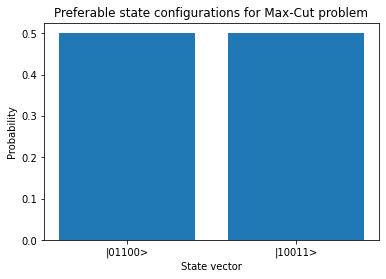

In [69]:
State_vectors = [str(sample.state) for sample in result if sample.probability > 1e-2] # Only displays state vector whose amplitude is above 1% (arbitrary)
Probabilities = [sample.probability for sample in result if sample.probability > 1e-2]
plt.bar(State_vectors, Probabilities)
plt.xlabel("State vector")
plt.ylabel("Probability")
plt.title("Preferable state configurations for Max-Cut problem")
plt.show()

The results are overall similar, even though the convergence seems slower in that case. This is surprising because the Adiabatic theorem requires the transition to be slow enough, so we would have assumed that for longer transition times $T$, the convergence would be better... 